In [1]:
import utils as ut

import os

import cv2 # ex1 , ex2
import numpy as np # ex1, ex2
import matplotlib.pyplot as plt # ex1
from skimage.filters import threshold_local # ex2
import math # ex2
from scipy import ndimage	# ex2
%matplotlib inline 


documents = os.listdir(ut.CORPUS)
doc_path = [ut.CORPUS + '/' + document for document in documents]

### Exemplo 1
PRO
> doesnt depent on orientation \
> doesnt depent on perspective \
> depends only on numpy and cv2

CONS
> Only works well in single documents with well delimited contours
> doent work on most files 

OBS
> can be used for for colored documents in order to eliminate background \
> reorientation idea can be implemented, but in another way \ 
> rezising image make it easier to process image

https://dontrepeatyourself.org/post/learn-opencv-by-building-a-document-scanner/ solution

In [2]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

def scan_document0(document):
    img = cv2.imread(document, cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.show()

    height = 800
    width = 600
    green = (0, 255, 0)

    image = cv2.imread(document) # can also read with input == 0 and skip gray
    image = cv2.resize(image, (width, height))
    orig_image = image.copy()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert the image to gray scale
    blur = cv2.GaussianBlur(gray, (5, 5), 0) # Add Gaussian blur
    edged = cv2.Canny(blur, 75, 200) # Apply the Canny algorithm to find the edges TODO Test other edge alg

    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)


    # plt.imshow(orig_image)

    image_contour = image.copy()
    cv2.drawContours(image_contour, contours, -1, green, 3)
    plt.figure()
    plt.imshow(image_contour)
    plt.show()

    # go through each contour
    for contour in contours:
        # we approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
        # if we found a countour with 4 points we break the for loop
        # (we can assume that we have found our document)
        if len(approx) == 4:
            doc_cnts = approx
            break

    # plt.imshow(orig_image)
    image_contour = image.copy()
    cv2.drawContours(image_contour, [doc_cnts], -1, green, 3)
    plt.figure()
    plt.imshow(image_contour)
    plt.show()

    # plt.imshow(image_contour)
    # plt.show()
    # apply warp perspective to get the top-down view
    warped = four_point_transform(orig_image, doc_cnts.reshape(4, 2))
    # # convert the warped image to grayscale
    # warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

    plt.imshow(cv2.resize(warped, (600, 800)))
    plt.show()

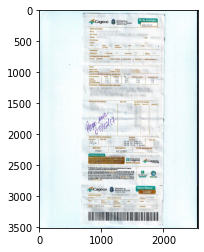

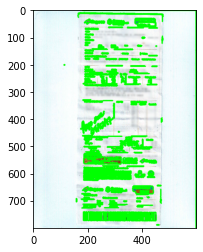

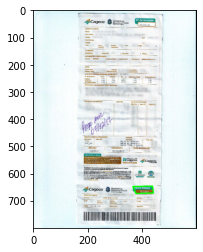

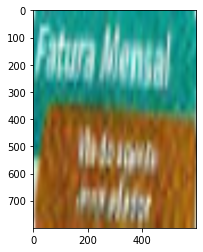

In [3]:
document = doc_path[4]
scan_document0(document)

### Exemplo 2

PRO
> scanning documents (threshold_local uses skimage) \
> rotate images \
> scan document using features of the document, (dont deppend on the background)

CONS
> hard to translate to C++, uses a lot of diferent libraries (skimage, math, scipy) \
> dont minimize whitespace (in fact creates blackspace)\ 
> SLOW 

OBS
> rotate image might be useful \
> scanning makes it easier to and lightier to process \
> doesnt work on some files 


https://medium.datadriveninvestor.com/document-scanner-from-scratch-with-python-6a55c7ce1423

In [10]:
class Scanner:

	def __init__(self, img):
		self.img = img

	def Rotation(self):
		# print("Rotation")
		# read the original image, copy it,
		# rotate it
		image = cv2.imread(self.img)
		orig = image.copy()
		
		image = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
		img_edges = cv2.Canny(image, 100, 100, apertureSize=3)
		lines = cv2.HoughLinesP(img_edges, rho=1, theta=np.pi / 180.0, threshold=160, minLineLength=100, maxLineGap=10)
		
		# calculate all the angles:
		angles = []
		for [[x1, y1, x2, y2]] in lines:
			angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
			angles.append(angle)
			
		# average angles
		median_angle = np.median(angles)
		# actual rotation
		image = ndimage.rotate(image, median_angle)

		# Saving an image itself
		cv2.imwrite(ut.tmp+'Part_rotation.png', image)
		return image
		
	def Scan_View(self):
		# print("Scanned View")
		# read the original image, copy it,
		# apply threshold to "scannify" it
		image = cv2.imread(self.img)
		orig = image.copy()
		
		# convert our image to grayscale, apply threshold
		# to create scanned view effect
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		thr = threshold_local(image, 11, offset = 10, method = "gaussian")
		image = (image > thr).astype("uint8") * 255

		# show the original image and the edge detected image
		# print(np.shape(orig), np.shape(image))
		#cv2.imshow("orig", orig)
		#cv2.imshow("Scanned", image)
		#cv2.waitKey(0)
		#cv2.destroyAllWindows()
    
		# Saving a B&W image itself
		cv2.imwrite(ut.tmp+'Part_scan_view.png', image)
		return image



In [11]:
# Defining the image name
img = doc_path[3]

# Calling the scanner class
scan = Scanner(img)

# Scanning the image -> B&W scheme
scanned_im = scan.Scan_View()

# Defining the image name
img = ut.tmp+"Part_scan_view.png"

# Calling the scanner class
scan = Scanner(img)
# Performing Rotation
rotated_im = scan.Rotation()


### Exemplo 3

PRO 
> short

CONS 
> doesnt work on a single document

OBS
> rectangle is a usefull tool

https://stackoverflow.com/questions/54430821/faster-way-to-trim-blank-noised-space-from-scanned-images


In [24]:
def scan_document1(document):
  img = cv2.imread(document)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #Separate the background from the foreground
  bit = cv2.bitwise_not(gray)

  nonzero = np.nonzero(bit)

  minx = min(nonzero[1])
  maxx = max(nonzero[1])

  miny = min(nonzero[0])
  maxy = max(nonzero[0])

  res = img[miny:maxy,minx:maxx].copy()

  cv2.rectangle(img,(minx,miny),(maxx,maxy),(0,0,255),2)

  # plt.imshow(img)
  cv2.imwrite(ut.tmp + 'rectangle.png',img)
  #plt.imshow(bit)
  plt.show()

In [23]:
img = doc_path[17]
scan_document1(img)

### PROBLEMS
1 - some backgrounds are not cleanwhite OK[B, C] \
2 - some backgrounds have noise OK[A]\
3 - the contour on most images is a solid blackline [D]\
4 - some scanners have two images of documents []\
5 - most files dont have a clear contour OK[B]\
6 - some files go up to the borders [E]\
7 - various files are rotated [F]

### SOLUTIONS 
A - Apply a local filter to delete imperfections in the background based on suroundings \
B - Apply a exponential filter no white values (make white whitier e back blacker)\ 
C - "scan" image - instead of local_threshhold use mean of image (EX2)\
D - Convolute image and get a minimum rectangle that encompass most the convoluted file - pad this file to exclude borders \
E - Expand\reduce rectangle so that it encompasses the entire file \
F - Change minimum quare to minimum quadrangle (EX1) \
G - Look for whitespace betweet document and cut them

XXX AI - seems to be too much for the current problem


